In [8]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the data
file = "../../outputfiles/hhbbgg_analyzer-trees.root"
key = "/GGJets/preselection"

keys = [
    'bbgg_mass', 'dibjet_pt', 'diphoton_pt', 'bbgg_pt', 'bbgg_eta', 'bbgg_phi',
    'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi',
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi',
    'sublead_bjet_eta', 'sublead_bjet_phi', 'sublead_bjet_PNetB',
    'lead_bjet_PNetB', 'CosThetaStar_gg', 'CosThetaStar_jj', 'CosThetaStar_CS',
    'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 'FirstJet_PtOverM',
    'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass', 'weight_preselection'
]

with uproot.open(file) as f:
    signal_df = f[key].arrays(keys, library="pd")

signal_df['label'] = 1
print('Signal DataFrame shape:', signal_df.shape)

# Features and labels
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi',
    'sublead_pho_eta', 'sublead_pho_phi', 'diphoton_eta', 'diphoton_phi',
    'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt',
    'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi',
    'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg',
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM',
    'phosublead_PtOverM', 'FirstJet_PtOverM', 'SecondJet_PtOverM',
    'diphoton_bbgg_mass', 'dibjet_bbgg_mass'
]
X_signal = signal_df[features]
y_signal = signal_df['label']
weight_signal = signal_df['weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_signal_imputed = imputer.fit_transform(X_signal)
scaler = StandardScaler()
X_signal_scaled = scaler.fit_transform(X_signal_imputed)

# Convert to torch tensors
X_signal_tensor = torch.tensor(X_signal_scaled, dtype=torch.float32)
y_signal_tensor = torch.tensor(y_signal.values, dtype=torch.long)
weight_signal_tensor = torch.tensor(weight_signal.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
signal_data = TensorDataset(X_signal_tensor, y_signal_tensor, weight_signal_tensor)
signal_loader = DataLoader(signal_data, batch_size=32, shuffle=False)

# Define the model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

input_dim = X_signal_scaled.shape[1]
model = SimpleDNN(input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

# # Define a function to get predictions from the PyTorch model
# def get_predictions(loader, model):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels, _ in loader:
#             outputs = model(inputs)
#             outputs = outputs.squeeze()
#             all_preds.extend(outputs.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#     return np.array(all_preds), np.array(all_labels)

# # Get predictions for the signal data
# signal_preds, signal_true = get_predictions(signal_loader, model)


Signal DataFrame shape: (46802, 34)


SimpleDNN(
  (fc1): Linear(in_features=29, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [9]:
# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    all_weights = []
    with torch.no_grad():
        for inputs, labels, weights in loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_weights.extend(weights.cpu().numpy())
    return np.array(all_preds), np.array(all_labels), np.array(all_weights)


In [10]:
# Get predictions for the signal data
signal_preds, signal_true, signal_weights = get_predictions(signal_loader, model)


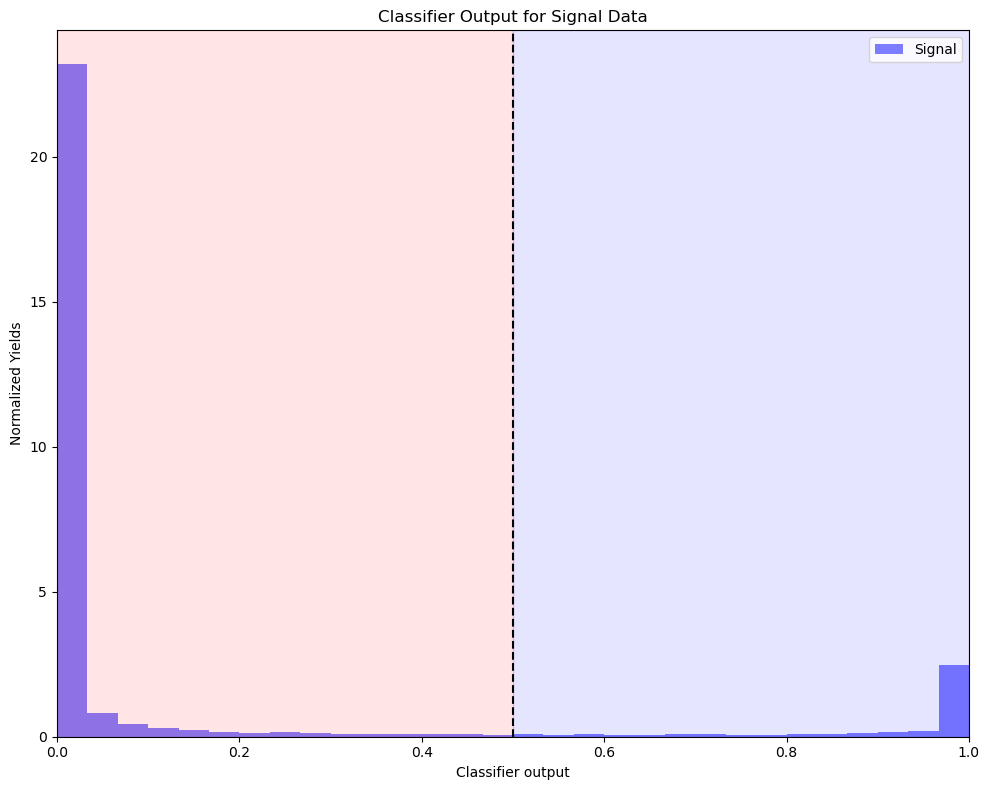

In [12]:
# Evaluate performance
accuracy = accuracy_score(signal_true, (signal_preds > 0.5).astype(int))
roc_auc = roc_auc_score(signal_true, signal_preds)
report = classification_report(signal_true, (signal_preds > 0.5).astype(int))

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Classification Report:")
print(report)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for signal data
plt.figure(figsize=(10, 8))
plt.hist(signal_preds[signal_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal', density=True, weights=weight_signal_tensor.numpy()[signal_true == 1])

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Signal Data')

# Save and display the plot
# plt.savefig("../bdtplots/dnn/DNN_signal_classifier_output_plot.png")
# plt.savefig("../bdtplots/dnn/DNN_signal_classifier_output_plot.pdf")
plt.tight_layout()
plt.show()


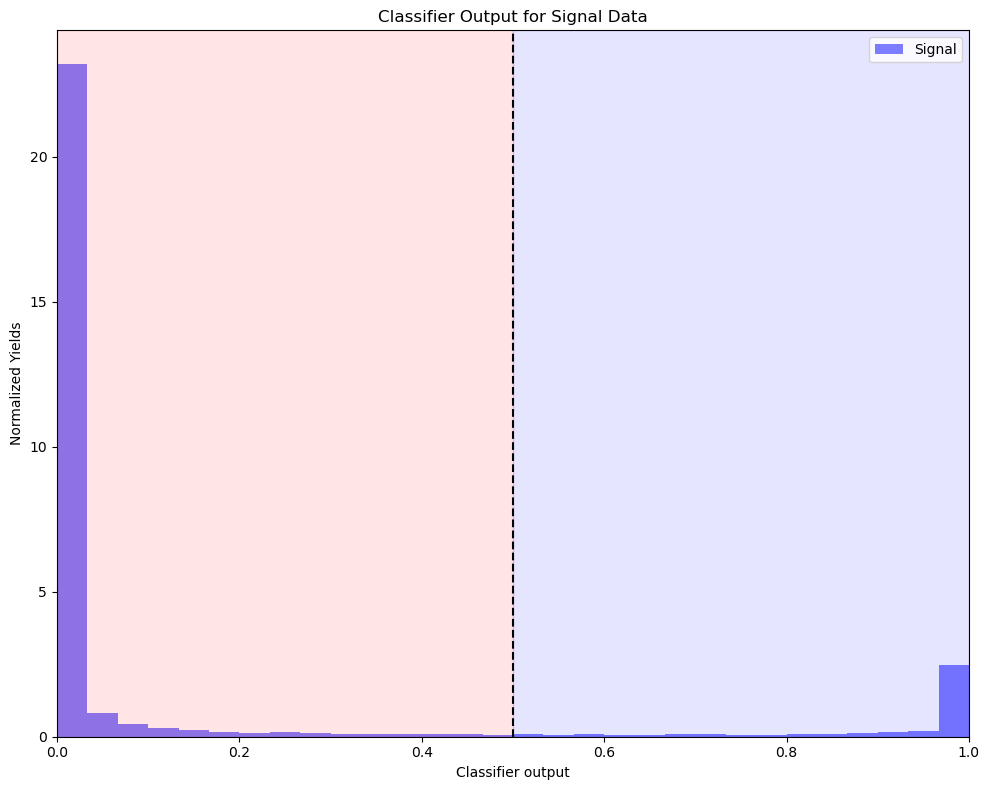

Histogram data saved to signal_histogram.root


In [14]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import hist

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms for signal data with weights
signal_hist_s, bin_edges = np.histogram(signal_preds[signal_true == 1], bins=bins, density=True, weights=weight_signal_tensor.numpy()[signal_true == 1])

# Plot histograms for signal data
plt.figure(figsize=(10, 8))
plt.hist(signal_preds[signal_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal', density=True, weights=weight_signal_tensor.numpy()[signal_true == 1])

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Signal Data')

# Save and display the plot
plt.tight_layout()
plt.show()

# Save the histogram data to a ROOT file
root_file_path = "signal_histogram.root"

# Create the histogram object
histogram = hist.Hist(
    hist.axis.Regular(bins=len(bins) - 1, start=bins[0], stop=bins[-1], name="classifier_output"),
    storage=hist.storage.Weight()
)

# Fill the histogram with the signal data
histogram.fill(classifier_output=signal_preds[signal_true == 1], weight=weight_signal_tensor.numpy()[signal_true == 1])

# Save the histogram to a ROOT file
with uproot.recreate(root_file_path) as f:
    f["signal_hist"] = histogram

print(f"Histogram data saved to {root_file_path}")


In [15]:
import uproot


In [16]:
file = uproot.open("../../outputfiles/hhbbgg_analyzer-histograms.root")

In [20]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import ROOT

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms for signal data with weights
signal_hist_s, bin_edges = np.histogram(signal_preds[signal_true == 1], bins=bins, density=True, weights=weight_signal_tensor.numpy()[signal_true == 1])

# Plot histograms for signal data
plt.figure(figsize=(10, 8))
plt.hist(signal_preds[signal_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal', density=True, weights=weight_signal_tensor.numpy()[signal_true == 1])

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Signal Data')

# Save and display the plot
plt.tight_layout()
plt.show()

# Create the TH1F histogram object using ROOT
histogram_name = "preselection-dnn_classifierScore"
histogram_title = "DNN Classifier Score; Classifier Output; Normalized Yields"
num_bins = len(bins) - 1

# Create ROOT histogram
root_histogram = ROOT.TH1F(histogram_name, histogram_title, num_bins, bins[0], bins[-1])

# Fill the ROOT histogram with the calculated histogram values
for i in range(num_bins):
    bin_center = (bins[i] + bins[i + 1]) / 2
    bin_content = signal_hist_s[i]
    root_histogram.Fill(bin_center, bin_content)

# Save the histogram to the ROOT file
root_file_path = "../../outputfiles/hhbbgg_analyzer-histograms.root"
root_file = ROOT.TFile(root_file_path, "UPDATE")
root_file.cd("GGJets")
root_histogram.Write()
root_file.Close()

print(f"Histogram '{histogram_name}' saved to {root_file_path} in GGJets directory")


/usr/local/lib/cppyy/__init__.py:72: SyntaxWarning: invalid escape sequence '\d'
  if re.match('^libcppyy_backend\d+_\d+$', lib_name):
/usr/local/lib/cppyy/__init__.py:72: SyntaxWarning: invalid escape sequence '\d'
  if re.match('^libcppyy_backend\d+_\d+$', lib_name):


ImportError: Failed to import libcppyy3_12. Please check that ROOT has been built for Python 3.12